# Opendoor Take Home Problem: Data Scientist

## Data Preprocessing
* I sorted the data by the close time, so that it could handle the problem of time leakage.

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
raw_data = pd.read_csv('data.csv',parse_dates=['close_date'])
raw_data.head()

,latitude,longitude,close_date,close_price
0,1.501986,86.350685,2014-08-16 22:25:31.925431,1.302246e+06
1,36.367095,-98.664280,2014-08-05 06:34:00.165876,1.475045e+05
2,36.599284,-97.924700,2014-08-12 23:48:00.887510,1.374006e+05
3,67.994791,64.688589,2014-08-17 05:27:01.404296,-1.411200e+04
4,36.647982,-97.866100,2014-08-09 04:00:40.358242,2.391053e+05


In [3]:
data = raw_data.sort_values(by=['close_date'])
data.head()

,latitude,longitude,close_date,close_price
45792,36.161727,-98.123455,2013-12-31 04:47:10.005660,56935.085184
45806,36.482000,-98.051300,2014-01-01 01:58:30.098593,481654.393156
45808,36.186023,-98.176310,2014-01-03 00:22:57.683471,-97482.000000
45771,36.278290,-98.957650,2014-01-04 01:13:42.187433,169432.247122
34839,-86.327535,139.708530,2014-01-05 13:29:17.311107,261704.565376


In [4]:
data.loc[45792]

latitude                          36.1617
longitude                        -98.1235
close_date     2013-12-31 04:47:10.005660
close_price                       56935.1
Name: 45792, dtype: object

## Using the dataset provided, please build a k-NN model for k = 4 that avoids time leakage (details below).
* It's a regression problem using KNN model. 
* To aviod time leakage, I sorted the dataset by the close time. And for each new test point, I used all other data which has a earlier close date as the training data.
* Calculated the euclidean distance among points and find the cloest 4 points.
* Assigning uniform weight for each neightbour point and sum them up as the predict price.
* Evaluating the performance by measuring the error of the predict price and the ground truth.

In [28]:
def getNeightbour(train,test,k):
    distance = []
    pred_price = 0
    
    train_mat = train.iloc[:,:2].as_matrix()
    test = test.iloc[:,:2].as_matrix()
    
    distance = np.sqrt(np.sum((train_mat - test)**2,axis=1))
    min_index = np.argsort(distance)
    
    for i in range(k):
        index = min_index[i]
        pred_price += train.iloc[index,-1] / k
        
    return pred_price

In [30]:
k = 4
predict_price = []
for i in range(k,len(data)):
    if (i % 5000) == 0:
        print(i)
    predict = getNeightbour(data[:i],data[i:i+1],k)
    predict_price.append(predict)

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000


## What is the performance of the model measured in Median Relative Absolute Error?
* The Median of Relative Absolute Error is about 24.4%

In [39]:
np.median(abs(predict_price - true_price) / predict_price)

0.24431845066280169

## What would be an appropriate methodology to determine the optimal k?
* The optimum K will always vary depending of the data set. The best method is to try many K values and figure out the error relatively to see which K value is giving the best result.

## Do you notice any spatial or temporal trends in error?
* In this particular case, as the time goes on, more and more data will come into the training set. We could expect that the distance between new test data point and its neightbours will become smaller. (As shown on the graph below)
* If the assumption of the model works well - prices are highly correlated to neightbours, then there should be a decreasing trend in error as the time move on, since we have more data in the training set, so that data point coming later will have neighbours close enough for the model to predict a more accurate price.

In [101]:
def getTrend(train,test,k):
    min_dis = 0
    
    train_mat = train.iloc[:,:2].as_matrix()
    test = test.iloc[:,:2].as_matrix()
    
    distance = np.sqrt(np.sum((train_mat - test)**2,axis=1))
    min_dis += np.sort(distance)[:k]
    
    return min_dis

In [102]:
k = 4
distance = []
for i in range(k,len(data)):
    if (i % 5000) == 0:
        print(i)
    distance.append(getTrend(data[:i],data[i:i+1],k))

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000


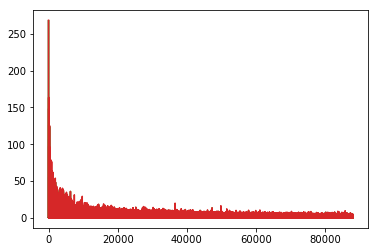

In [103]:
plt.plot(distance)

## How would you improve this model?
* One way is by implementing weighed voting. The K neighbors is multiplied by a weight proportional to the inverse of the distance from that point to the given test point. This ensures that nearer neighbors contribute more to the final vote than the more distant ones. (Implementation are shown below, and it gave a lower median relative absolute error.)
* Another way is to normalize the data, which makes the distance metric more meaningful.
* Or maybe try some other distance functions.

In [88]:
def getNeightbour_distance(train,test,k):
    distance = []
    pred_price = 0
    
    train_mat = train.iloc[:,:2].as_matrix()
    test = test.iloc[:,:2].as_matrix()
    
    distance = np.sqrt(np.sum((train_mat - test)**2,axis=1))
    min_index = np.argsort(distance)
    total_weight = sum(1/(np.sort(distance)[:4]+0.01))
    weight = (1/(np.sort(distance)[:4]+0.01)) / total_weight
    
    for i in range(k):
        index = min_index[i]
        pred_price += train.iloc[index,-1] * weight[i]
        
    return pred_price

In [89]:
k = 4
predict_price_distance = []
for i in range(k,len(data)):
    if (i % 5000) == 0:
        print(i/len(data))
    predict = getNeightbour_distance(data[:i],data[i:i+1],k)
    predict_price_distance.append(predict)

0.056791076985983964
0.11358215397196793
0.1703732309579519
0.22716430794393586
0.2839553849299198
0.3407464619159038
0.39753753890188775
0.4543286158878717
0.5111196928738556
0.5679107698598396
0.6247018468458236
0.6814929238318076
0.7382840008177916
0.7950750778037755
0.8518661547897595
0.9086572317757434
0.9654483087617274


In [90]:
np.median(abs(predict_price_distance - true_price)/predict_price_distance)

0.24138751467410818

## How would you productionize this model?
* As mentioned before, if the assumption of this model works well, this model could be used to predict the approximate selling price of a new listed house on the website as reference for the users, based on the price of its several K neightbours which are also listed on the website, so that the users can consider how the factor of location affects the price of their houses.